# CatBoost

In [1]:
#pip install progressbar2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time  
import ast
import pytz

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from sklearn.metrics import precision_recall_curve, make_scorer
from sklearn.metrics import roc_curve, auc

import progressbar
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

import catboost as cb

In [3]:
df = pd.read_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\encoded_w_outliers.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9804 entries, 0 to 9803
Columns: 247 entries, user_is_clicker to user_primary_category_d90_162.0
dtypes: float64(4), int64(243)
memory usage: 18.5 MB


In [5]:
X = df.drop(['target'],axis=1)
y = df['target']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1,stratify=y)

In [6]:
#Let us load the Model Performance dataframe that we created in the previous notebooks
#It contains performance summary of the earlier models
performance_df = pd.read_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\performance_df.csv")

In [7]:
# Function to add model's performance to the DataFrame
def add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc, log_loss_value):
    new_row = {
        'Model Name': model_name,
        'Elapsed Time': elapsed_time,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc,
        'Log Loss': log_loss_value
    }
    return performance_df.append(new_row, ignore_index=True)

In [8]:
#Function to summarize model performance and then update Model Performance Dataframe
def summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df):
    """
    Summarize and plot the performance of a trained model and add its performance metrics to an existing DataFrame.
    """

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Check if predictions are continuous (e.g., probabilities)
    if y_pred.ndim > 1 or np.any((y_pred % 1) != 0):
        # Convert continuous predictions to binary labels
        y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    else:
        y_pred_binary = y_pred

    # Compute the confusion matrix
    confusion = confusion_matrix(y_test, y_pred_binary)

    # Compute ROC curve and ROC AUC
    # Check if the model supports predict_proba
    if hasattr(model, 'predict_proba'):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # Use binary predictions as probabilities if predict_proba is not available
        y_prob = y_pred_binary

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Create a figure with two subplots for confusion matrix and ROC curve
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the confusion matrix
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    # Plot the ROC curve
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {roc_auc:.4f}')
    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.0])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # Compute main metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    roc_auc_score_value = roc_auc_score(y_test, y_prob)
    log_loss_value = log_loss(y_test, y_prob)

    # Update the performance DataFrame
    performance_df = add_model_performance(performance_df, model_name, elapsed_time, accuracy, precision, recall, f1, roc_auc_score_value, log_loss_value)

    return performance_df

# CatBoost - Basic

In [9]:
model_name = "CatBoost - Basic"

# Start the timer
start_time = time.time()

cat_boost_basic = cb.CatBoostClassifier(silent=True)

# Train the model
cat_boost_basic.fit(X_train, y_train)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Elapsed Time: 4.224025249481201


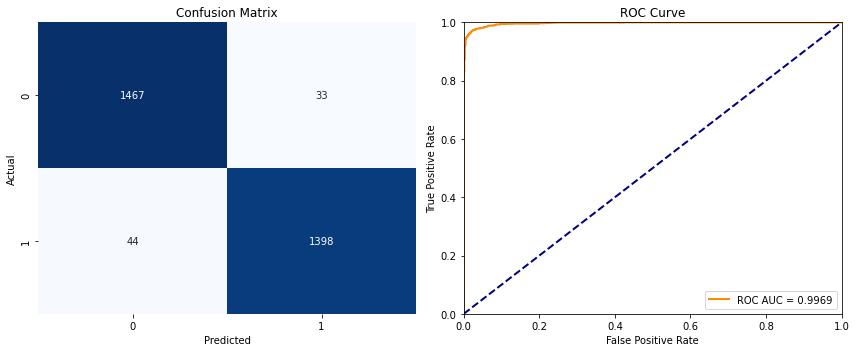

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134
8,KNN - Optimized,59.846456,0.958192,0.972760,0.941054,0.956644,0.957860,0.236475
9,SVM - Basic,5.061740,0.973148,0.990641,0.954230,0.972095,0.972782,0.087060


In [10]:
# Let us check performance
model = cat_boost_basic
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

**Observation:**
- Catboost performs quite well. Lags XGBoost slightly.
- Let us see if we can optimize it

# CatBoost - Optimized

In [11]:
model_name = "CatBoost - Optimized"

# Start the timer
start_time = time.time()

# Initialize the CatBoostClassifier
catboost_optimized = cb.CatBoostClassifier(loss_function='Logloss')

# Define the parameter grid to search
param_grid = {
    'iterations': [800, 1000, 1200],
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.05, 0.1, 0.15],
    'l2_leaf_reg': [2, 3, 4],
    'border_count': [64, 128, 254],
    'random_strength': [1e-6, 1e-3, 1]
}

# Initialize the CatBoostClassifier
catboost_optimized = cb.CatBoostClassifier(loss_function='Logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=catboost_optimized, param_grid=param_grid, cv=5, scoring='neg_log_loss', verbose=0)

# Fit the grid search to the data
grid_search.fit(X_train, y_train, verbose=0)

# Print the best parameters found
print("Best parameters found: ", grid_search.best_params_)

# End the timer
end_time = time.time()

elapsed_time = end_time - start_time
print('Elapsed Time:', elapsed_time)

Best parameters found:  {'border_count': 254, 'depth': 10, 'iterations': 800, 'l2_leaf_reg': 4, 'learning_rate': 0.05, 'random_strength': 1}
Elapsed Time: 26769.570731163025


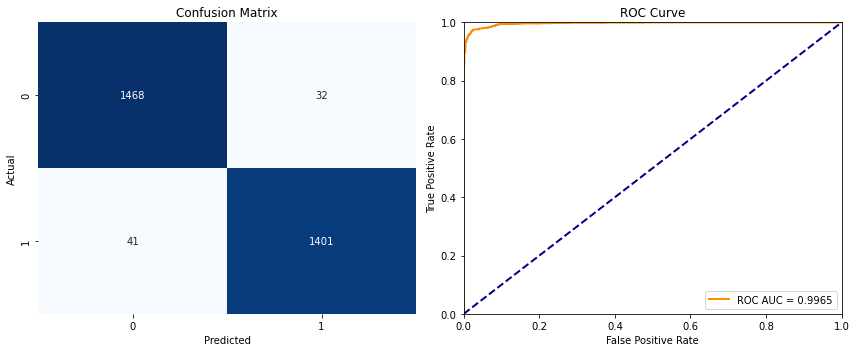

,Model Name,Elapsed Time,Accuracy,Precision,Recall,F1 Score,ROC AUC,Log Loss
0,Baseline,0.000967,0.509857,0.000000,0.000000,0.000000,0.500000,16.928931
1,Decision Tree - Basic,0.055700,0.968729,0.972028,0.963939,0.967967,0.968636,0.927700
2,Decision Tree - Optimized,27.064759,0.967369,0.968663,0.964632,0.966644,0.967316,0.127090
3,Random Forest - Basic,0.646206,0.973487,0.974930,0.970874,0.972898,0.973437,0.192965
4,Random Forest - Optimized,190.961700,0.974167,0.978291,0.968793,0.973519,0.974063,0.089496
5,Logistic Regression - Basic,0.110738,0.972128,0.991329,0.951456,0.970984,0.971728,0.078890
6,Logistic Regression - Optimized,236.307246,0.972468,0.991336,0.952150,0.971348,0.972075,0.080955
7,KNN - Basic,0.007982,0.970768,0.972145,0.968100,0.970118,0.970717,0.470134
8,KNN - Optimized,59.846456,0.958192,0.972760,0.941054,0.956644,0.957860,0.236475
9,SVM - Basic,5.061740,0.973148,0.990641,0.954230,0.972095,0.972782,0.087060


In [13]:
# Let us check performance
model = grid_search.best_estimator_
performance_df = summarize_model_performance(model, X_test, y_test, model_name, elapsed_time, performance_df)
performance_df

## Conclusion:
- CatBoost is an interesting ensemble model. It is known to perform very well with the default settings, which is what happened. Optimization did not produce an improvement--even after a very long run.
- Optimized XGBoost is still our best model.

## Summary graph of all model performance

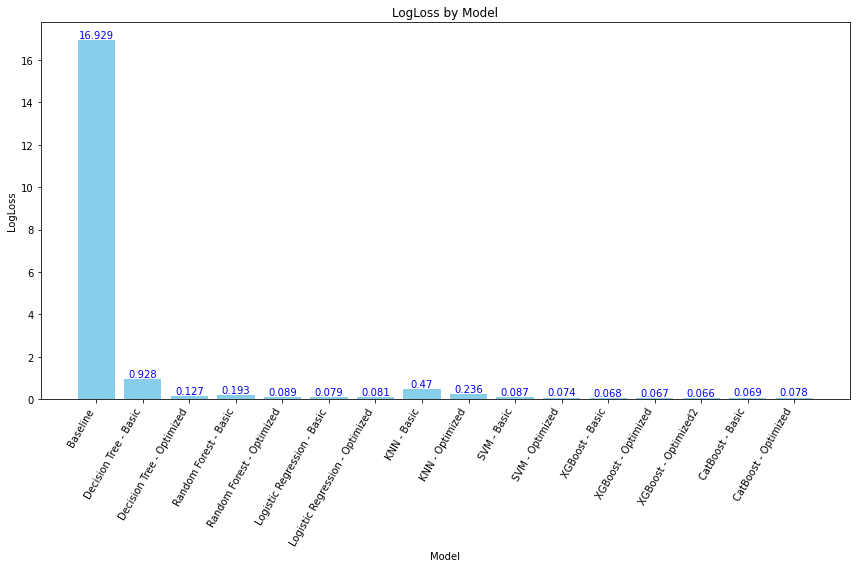

In [14]:
import matplotlib.pyplot as plt
# Plotting the bar graph for LogLoss by Model with annotations
plt.figure(figsize=(12, 8))
bars = plt.bar(performance_df['Model Name'], performance_df['Log Loss'], color='skyblue')

# Adding the text annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), va='bottom', ha='center', color='blue')

plt.xlabel('Model')
plt.ylabel('LogLoss')
plt.title('LogLoss by Model')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [15]:
#Let us export the performance datafraome to .csv
performance_df.to_csv(r"C:\Users\dkaza\Documents\0 Berkeley - ML and AI\0_Capstone\performance_df.csv", index=False)